In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
%matplotlib inline


In [61]:
df =  pd.read_csv('german_credit_data.csv')
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [62]:
df['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [63]:
X = df.drop('Risk',axis=1)
Y = df['Risk']
X = pd.get_dummies(X,drop_first=True)
Y = pd.get_dummies(Y,drop_first=True)

In [64]:
for col in X.columns:
    X[col] = X.apply(lambda rec : 1 if rec[col]==True else rec[col], axis=1) 
    X[col] = X.apply(lambda rec : 0 if rec[col]==False else rec[col], axis=1)
for col in Y.columns:
    Y[col] = Y.apply(lambda rec : 1 if rec[col]==True else rec[col], axis=1) 
    Y[col] = Y.apply(lambda rec : 0 if rec[col]==False else rec[col], axis=1)

In [65]:
X = sm.add_constant(X)

train_x , test_x , train_y, test_y = train_test_split(X,Y,train_size=0.7, random_state=42)

In [67]:
log_model = sm.Logit(train_y,train_x).fit()
print(log_model.summary2())

Optimization terminated successfully.
         Current function value: 0.543543
         Iterations 6
                              Results: Logit
Model:                  Logit               Method:              MLE       
Dependent Variable:     good                Pseudo R-squared:    0.108     
Date:                   2024-10-19 06:33    AIC:                 802.9604  
No. Observations:       700                 BIC:                 898.5331  
Df Model:               20                  Log-Likelihood:      -380.48   
Df Residuals:           679                 LL-Null:             -426.75   
Converged:              1.0000              LLR p-value:         2.6484e-11
No. Iterations:         6.0000              Scale:               1.0000    
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const            

In [68]:
# Finding columns having p-value < 0.05

In [74]:
significant_features = log_model.pvalues[log_model.pvalues <= 0.05].index
print(significant_features)
X = X[np.array(significant_features)]

Index(['Age', 'Duration', 'Housing_own', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_moderate',
       'Purpose_radio/TV'],
      dtype='object')


In [77]:
train_x , test_x , train_y, test_y = train_test_split(X,Y,train_size=0.7, random_state=42)
log_model = sm.Logit(train_y,train_x).fit()
print(log_model.summary2())

Optimization terminated successfully.
         Current function value: 0.550915
         Iterations 6
                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    good                Pseudo R-squared:    0.096     
Date:                  2024-10-19 06:42    AIC:                 785.2812  
No. Observations:      700                 BIC:                 817.1387  
Df Model:              6                   Log-Likelihood:      -385.64   
Df Residuals:          693                 LL-Null:             -426.75   
Converged:             1.0000              LLR p-value:         1.2377e-15
No. Iterations:        6.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Age                         

In [82]:
pred_df = pd.DataFrame()
pred_df['pred_good_prob'] = log_model.predict(test_x)
pred_df['pred_good'] = pred_df.apply(lambda rec : 1 if rec['pred_good_prob'] > 0.5 else 0, axis=1) 
pred_df['actual_good'] = test_y
print(pred_df.head())

     pred_good_prob  pred_good  actual_good
521        0.803411          1            0
737        0.744483          1            1
740        0.686878          1            1
660        0.722372          1            1
411        0.641553          1            1


              precision    recall  f1-score   support

           0       0.43      0.16      0.24        91
           1       0.71      0.90      0.80       209

    accuracy                           0.68       300
   macro avg       0.57      0.53      0.52       300
weighted avg       0.63      0.68      0.63       300



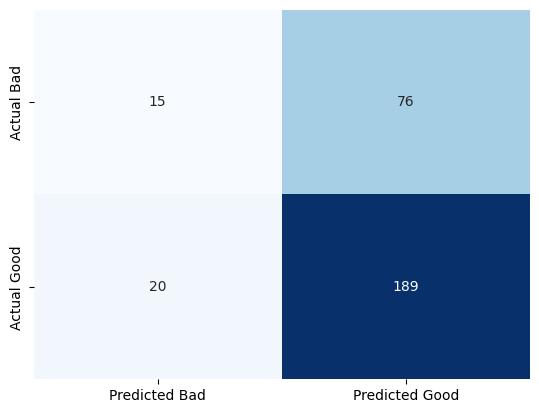

In [92]:
# Confustion Matrix
""" 
    REMEMBER 
    1. [ True Negative (TN), False Negative (FN)
        False Positive (FP), True Positive (TP)]
    2. True Negative (TN): Correctly predicted "Bad" (negative class).
    3. False Positive (FP): Incorrectly predicted "Good" (positive class) when it was actually "Bad".
    4. False Negative (FN): Incorrectly predicted "Bad" when it was actually "Good".
    5. True Positive (TP): Correctly predicted "Good" (positive class).

"""

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true=pred_df['actual_good'], y_pred=pred_df['pred_good'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted Bad', 'Predicted Good'], yticklabels=['Actual Bad', 'Actual Good'])
print(classification_report(pred_df['actual_good'], pred_df['pred_good']))

AUC Score: 0.5345706924654292


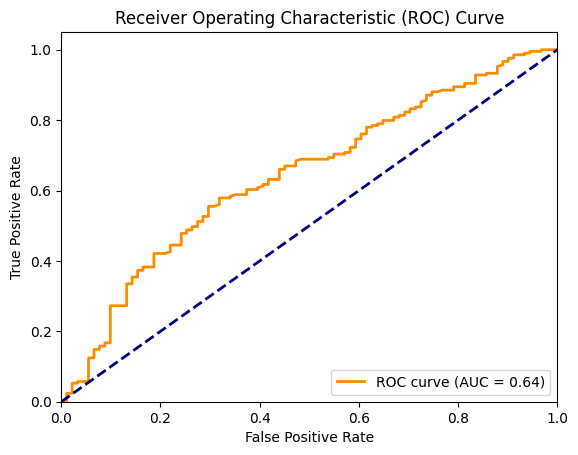

In [98]:
# ROC AUC 
""" 
    REMEMBER 
    1. If AUC score for ROC curve == 0.5 then same as random guess
    2. < 0.5 worst than random guessing
    3. > 0.5 better than random guessing
    4. >= 0.7 for modal to be used
    5. fpr -> False Positive Rate
    6. tpr -> True Positive Rate

"""

from sklearn.metrics import roc_auc_score, roc_curve, auc
print(f"AUC Score: {roc_auc_score(pred_df['actual_good'],pred_df['pred_good'])}")

fpr, tpr, thresholds = roc_curve(pred_df['actual_good'], pred_df['pred_good_prob']) 
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [96]:
# Finding best probability cutoff we used 0.5

In [100]:
tpr_fpr = pd.DataFrame({
    'tpr': tpr,
    'fpr': fpr,
    'thresholds': thresholds
})

tpr_fpr['diff'] = tpr_fpr['tpr'] - tpr_fpr['fpr']

top5_thresholds = tpr_fpr.sort_values('diff', ascending=False).head(5)
print(top5_thresholds)

# optimal threshold is 0.73

         tpr       fpr  thresholds      diff
60  0.578947  0.318681    0.736373  0.260266
56  0.555024  0.296703    0.740307  0.258321
59  0.569378  0.318681    0.736547  0.250697
57  0.555024  0.307692    0.739894  0.247332
55  0.540670  0.296703    0.744483  0.243967


In [101]:
pred_df['pred_good'] = pred_df.apply(lambda rec : 1 if rec['pred_good_prob'] > 0.73 else 0, axis=1)

print(f"AUC Score: {roc_auc_score(pred_df['actual_good'],pred_df['pred_good'])}")

AUC Score: 0.6184341973815657


In [102]:
# cost based approach

In [103]:
# Gain chart and lift chart